# Import all important libs

In [1]:
# Imports here
import torch
import json
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
from torch.optim import lr_scheduler
from PIL import Image
%matplotlib inline

### Chck if there is any GPU avalible for training

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [3]:
batch_size = 28

## Setting all important dirs for this phase

In [5]:
# Dataset dir base
dataset_dir = '/home/helpthx/Documents/TCC-1-dataset/dataset-split'
train_dir = dataset_dir + '/train'
valid_dir = dataset_dir + '/val'
test_dir = dataset_dir + '/test'

# Model dir 
pre_model_dir='/home/helpthx/Desktop/TCC-1/TCC-1-UnB/architectures/restnet152_pytorch/teste_2/restnet_model152_1.pt'

# Image test from test_dir
image_test_dir='/home/helpthx/Documents/TCC-1-dataset/dataset-split/test/basal-cell-carcinoma/basal-cell-carcinoma_original_3210.jpg_6e88dd4a-6a26-4c3c-a21d-8c92f9cd35f8.jpg'

In [6]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean,
                                        std)
                                      ])

valid_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean,
                                        std)
                                      ])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean,
                                        std)
                                      ])

# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir,transform = train_transforms)
valid_data = datasets.ImageFolder(valid_dir,transform = valid_transforms)
test_data = datasets.ImageFolder(test_dir,transform = test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

## Loading restnet152 pretrainer model and set fullyconnected layer to 12

In [7]:
model = models.resnet152(pretrained=True)
model.fc = nn.Linear(2048, 12)

## Loading pre-trained model from google colab

In [8]:
if train_on_gpu:
    state = torch.load(pre_model_dir)
else:
    state = torch.load(pre_model_dir, map_location='cpu')

# Loading weights in restnet architecture
model.load_state_dict(state['state_dict'])

<All keys matched successfully>

## Built-in functions to help

In [9]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Resize where shortest side is 256px, keeping aspect ratio
    minside = 256
    img = Image.open(image)
    imagex, imagey = img.size
    aspect = float(imagex)/float(imagey)
    
    if imagex <= imagey:
      width = 256
      height = int(width/aspect)
    else:
      height = 256
      width = int(height*aspect)
   
    img = img.resize((width,height),Image.ANTIALIAS)
    
    # Crop out center 224 x 224
    left = (width - 224)/2
    top = (height - 224)/2
    right = (width + 224)/2
    bottom = (height + 224)/2
    img = img.crop((left, top, right, bottom))
    
    # Convert image to numpy array
    np_image = np.array(img)
    np_image = np_image/255
    
    # Normalize image
    np_image -= [0.485, 0.456, 0.406]
    np_image /= [0.229, 0.224, 0.225]
    
    # Transpose array:
    result = np_image.transpose(-1,0,1)
    
    return result

In [10]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

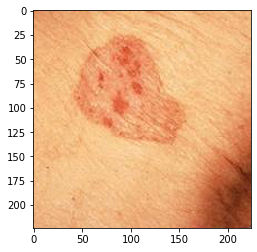

In [11]:
result = process_image(image_test_dir)
res = torch.from_numpy(result)
imshow(res)

## Function to make single predictions base on top5 most close match

In [89]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    model.eval()
    image = process_image(image_path)
    image = torch.from_numpy(image)
    if train_on_gpu:
      model.cuda()
      image = image.cuda()
    image = image.float().unsqueeze(0)
    out = model.forward(image)
    logps = F.log_softmax(out)
    ps = torch.exp(logps)
    probs, classes = ps.topk(topk, dim=1)
    if train_on_gpu:
      probs = list(probs.squeeze(0).cpu().detach().numpy())
      classes = list(classes.squeeze(0).cpu().detach().numpy())
    else:
      probs = list(probs.squeeze(0).detach().numpy())
      classes = list(classes.squeeze(0).detach().numpy())
    idx_class_mapping = dict((v,k) for k,v in train_data.class_to_idx.items())
    classes = list(map(lambda x: idx_class_mapping[x], classes))
    return probs, classes


In [90]:
probs, classes = predict(image_test_dir, model)
print(probs)
print(classes)

[0.662698, 0.15622197, 0.105245695, 0.040974703, 0.022275127]
['intraepithelial-carcinoma', 'basal-cell-carcinoma', 'malignant-melanoma', 'lentigo', 'squamous-cell-carcinoma']


/home/helpthx/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


## Load map number to name dict

In [99]:
with open('/home/helpthx/Desktop/TCC-1/TCC-1-UnB/skin_lesion_to_name.json', 'r') as f:
    skin_lesion_to_name = json.load(f)

In [109]:
skin_lesion_to_name.keys()

dict_keys(['dermatofibroma', 'malignant-melanoma', 'squamous-cell-carcinoma', 'pyogenic-granuloma', 'lentigo', 'actinic-keratosis', 'intraepithelial-carcinoma', 'melanocytic-nevus', 'seborrheic-keratosis', 'wart', 'basal-cell-carcinoma', 'hemangioma'])

'dermatofibroma'

In [100]:
list(skin_lesion_to_name)

['dermatofibroma',
 'malignant-melanoma',
 'squamous-cell-carcinoma',
 'pyogenic-granuloma',
 'lentigo',
 'actinic-keratosis',
 'intraepithelial-carcinoma',
 'melanocytic-nevus',
 'seborrheic-keratosis',
 'wart',
 'basal-cell-carcinoma',
 'hemangioma']

In [117]:
def plot_bar(image_path, model):
  result = process_image(image_path)
  res = torch.from_numpy(result)
  fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
  ax1 = imshow(res, ax1)
  probs, classes = predict(image_path,model)
  ax2.barh(np.arange(len(probs)), probs)
  ax2.set_aspect(0.1)
  ax2.set_yticks(np.arange(len(probs)))
  v = list(skin_lesion_to_name.keys())
  # classes = list(map(lambda x: skin_lesion_to_name[x], classes))
  ax2.set_yticklabels(classes, size='small');
  ax2.set_title('Class Probability')
  ax2.set_xlim(0, 1.1)
  plt.tight_layout()

/home/helpthx/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


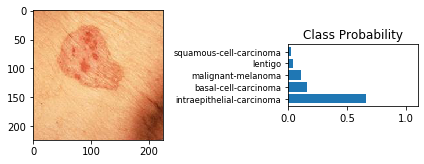

In [118]:
plot_bar(image_test_dir ,model)

## Test routine for test_dir

In [81]:
def test(model, testloader):

  model.eval()
  test_loss = 0.0

  class_correct = list(0. for i in range(102))
  class_total = list(0. for i in range(102))

  for data, target in testloader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()
    # forward pass:
    output = model(data)
    # calculate batch loss
    loss = criterion(output, target)
    # update validation loss
    test_loss += loss.item()*data.size(0)

    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate validation accuracy for each object class
    for i in range(target.data.size()[0]):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

  # calculate average losses
  test_loss = test_loss / len(testloader.dataset)

  # print training/validation statistics 
  print('Test Loss: {:.6f}'.format(test_loss))

  print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

In [ ]:
# Run just in google colab
# test(model,testloader)